In [ ]:
from scipy import stats
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [2]:
#percentage of snps high impact and between MAF brakets
#inversion_snps, total_outside
def get_counts(level, mytype,cname):

    file_path = os.path.expanduser(f'snpeff_remote/snpeff_results/{level}_{cname}_snpeff_freq.txt.frq')
    df1 = pd.read_csv(file_path, delimiter='\t')  # Use delimiter='\t' if the file is tab-separated
    df1[['ref', 'AF1']] = df1['N_CHR'].str.split(':', expand=True)
    df1[['alt', 'AF2']] = df1['{ALLELE:FREQ}'].str.split(':', expand=True)
    df1['MAF'] = df1[['AF1', 'AF2']].min(axis=1)
    df1['MAF'] = df1['MAF'].astype(float)

    file_path = os.path.expanduser(f'snpeff_remote/snpeff_results/{level}_{cname}_inv_snpeff_freq.txt.frq')
    df2 = pd.read_csv(file_path, delimiter='\t')
    df2[['ref', 'AF1']] = df2['N_CHR'].str.split(':', expand=True)
    df2[['alt', 'AF2']] = df2['{ALLELE:FREQ}'].str.split(':', expand=True)
    df2['MAF'] = df2[['AF1', 'AF2']].min(axis=1)
    df2['MAF'] = df2['MAF'].astype(float)
    #print(len(df1), len(df2))

    #take out inversion from background
    df_diff = df1.merge(df2, how='left', indicator=True)
    df1 = df_diff[df_diff['_merge'] == 'left_only'].drop(columns=['_merge'])

    counts = []
    if mytype == "all":
        counts.append(len(df1[df1["MAF"]<0.1]))
        counts.append(len(df1[(df1["MAF"]<0.2) & (df1["MAF"]>=0.1)]))
        counts.append(len(df1[(df1["MAF"]<0.3) & (df1["MAF"]>=0.2)]))
        counts.append(len(df1[(df1["MAF"]<0.4) & (df1["MAF"]>=0.3)]))
        counts.append(len(df1[(df1["MAF"]<0.5) & (df1["MAF"]>=0.4)]))
    else:
        counts.append(len(df2[df2["MAF"]<0.1]))
        counts.append(len(df2[(df2["MAF"]<0.2) & (df2["MAF"]>=0.1)]))
        counts.append(len(df2[(df2["MAF"]<0.3) & (df2["MAF"]>=0.2)]))
        counts.append(len(df2[(df2["MAF"]<0.4) & (df2["MAF"]>=0.3)]))
        counts.append(len(df2[(df2["MAF"]<0.5) & (df2["MAF"]>=0.4)]))

    return counts, df1, df2

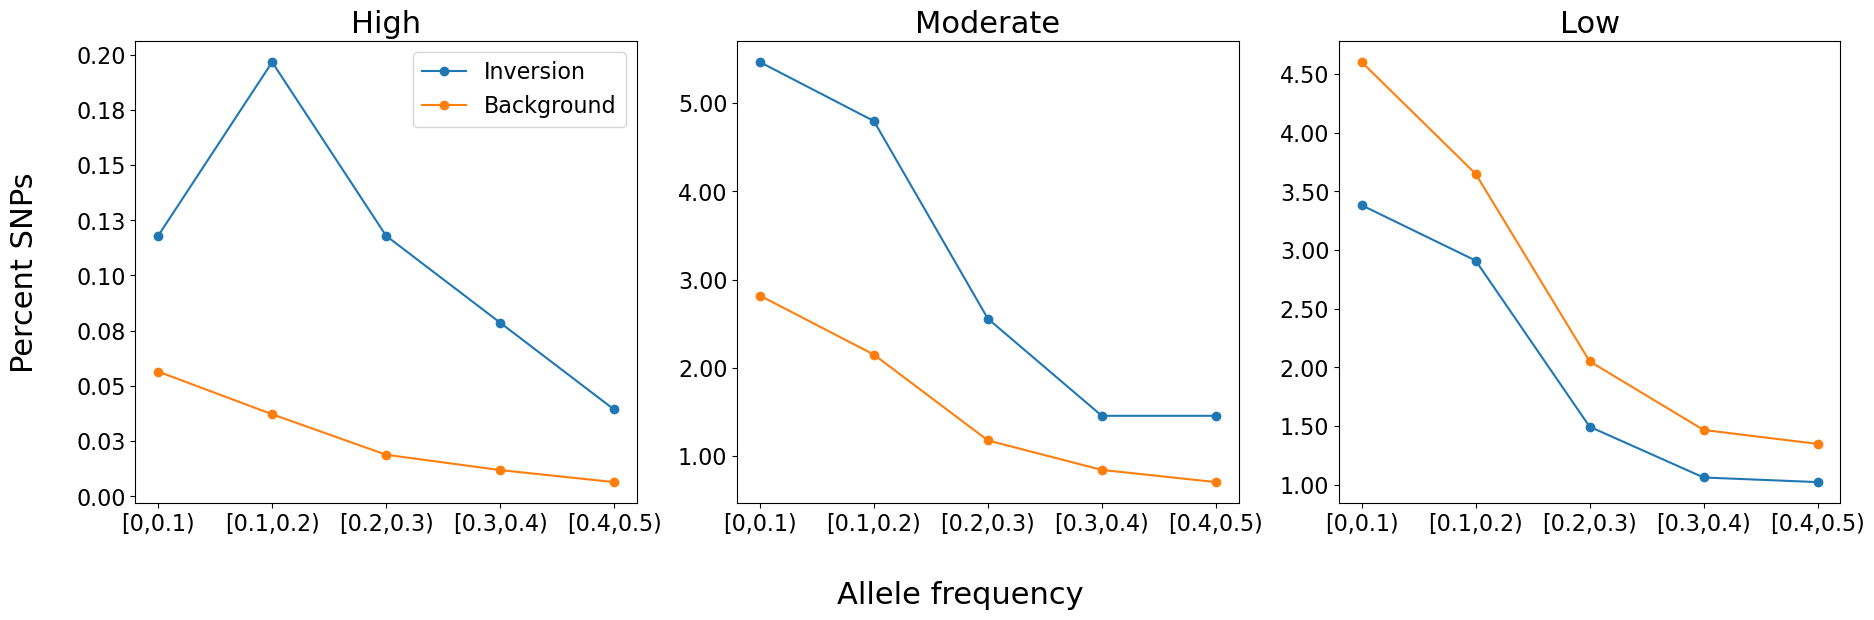

In [3]:
cname="594"
high_inv, _, _ = get_counts("high", "inv",cname)
medium_inv, _, _ = get_counts("mod", "inv",cname)
low_inv, _, _ = get_counts("low", "inv",cname)
high_out, _, _ = get_counts("high", "all",cname)
medium_out, _, _ = get_counts("mod", "all",cname)
low_out, _, _ = get_counts("low", "all",cname)

value_labels = ["[0,0.1)","[0.1,0.2)","[0.2,0.3)","[0.3,0.4)","[0.4,0.5)"]

df=pd.read_csv(f"snpeff_remote/snpeff_results/{cname}.csv", header=None)
df_inv=pd.read_csv(f"snpeff_remote/snpeff_results/{cname}_inv.csv", header=None)

total_snps = int(df.iloc[0][0])
inversion_snps = int(df_inv.iloc[0][0])
total_outside = total_snps - inversion_snps

total_intergenic = int(df.iloc[-1][0])
inversion_intergenic = int(df_inv.iloc[-1][0])
outside_intergenic = total_intergenic - inversion_intergenic

total_outside = total_outside - outside_intergenic
inversion_snps = inversion_snps - inversion_intergenic

values_total = np.array(df.iloc[1:7][0].tolist()).astype(int)
values_inverted = np.array(df_inv.iloc[1:7][0].tolist()).astype(int)
values_outside = values_total - values_inverted

f, axs = plt.subplots(1,3,figsize=(22, 6),sharex=True, sharey=False)

axs[0].plot(list(range(len(high_inv))),np.array(high_inv)/inversion_snps*100, marker="o",label="Inversion")
axs[0].plot(list(range(len(high_inv))),np.array(high_out)/total_outside*100, marker="o",label="Background")
axs[1].plot(list(range(len(high_inv))),np.array(medium_inv)/inversion_snps*100, marker="o")
axs[1].plot(list(range(len(high_inv))),np.array(medium_out)/total_outside*100, marker="o")
axs[2].plot(list(range(len(high_inv))),np.array(low_inv)/inversion_snps*100, marker="o")
axs[2].plot(list(range(len(high_inv))),np.array(low_out)/total_outside*100, marker="o")

axs[0].set_xticks(list(range(len(high_inv))), value_labels)
axs[1].set_xticks(list(range(len(high_inv))), value_labels)
axs[2].set_xticks(list(range(len(high_inv))), value_labels)

axs[0].set_title("High", fontsize=22)
axs[1].set_title("Moderate", fontsize=22)
axs[2].set_title("Low", fontsize=22)

plt.text(-0.25, 0.5, 'Percent SNPs', va='center', rotation='vertical', fontsize=22, transform=axs[0].transAxes)
plt.text(0.2, -0.2, 'Allele frequency', va='center', rotation='horizontal', fontsize=22, transform=axs[1].transAxes)

axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=16)

axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))
axs[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))

axs[0].legend(fontsize=16)

#plt.savefig("figs/594_AFs2.pdf", format='pdf', bbox_inches='tight')

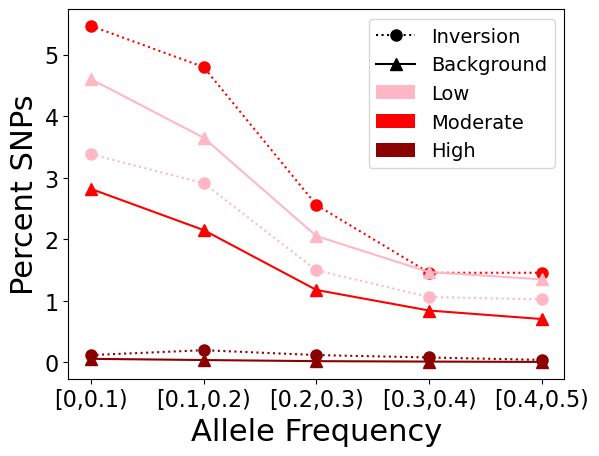

In [ ]:
cname="594"
high_inv, _, _ = get_counts("high", "inv",cname)
medium_inv, _, _ = get_counts("mod", "inv",cname)
low_inv, _, _ = get_counts("low", "inv",cname)
high_out, _, _ = get_counts("high", "all",cname)
medium_out, _, _ = get_counts("mod", "all",cname)
low_out, _, _ = get_counts("low", "all",cname)

value_labels = ["[0,0.1)","[0.1,0.2)","[0.2,0.3)","[0.3,0.4)","[0.4,0.5)"]

df=pd.read_csv(f"snpeff_remote/snpeff_results/{cname}.csv", header=None)
df_inv=pd.read_csv(f"snpeff_remote/snpeff_results/{cname}_inv.csv", header=None)

total_snps = int(df.iloc[0][0])
inversion_snps = int(df_inv.iloc[0][0])
total_outside = total_snps - inversion_snps

total_intergenic = int(df.iloc[-1][0])
inversion_intergenic = int(df_inv.iloc[-1][0])
outside_intergenic = total_intergenic - inversion_intergenic

total_outside = total_outside - outside_intergenic
inversion_snps = inversion_snps - inversion_intergenic

values_total = np.array(df.iloc[1:7][0].tolist()).astype(int)
values_inverted = np.array(df_inv.iloc[1:7][0].tolist()).astype(int)
values_outside = values_total - values_inverted

# plt.plot(list(range(len(high_inv))),np.array(high_inv)/inversion_snps*100, marker="o",label="Inversion",color="C0")
# plt.plot(list(range(len(high_inv))),np.array(high_out)/total_outside*100, marker="o",label="Background",color="C1")
# plt.plot(list(range(len(high_inv))),np.array(medium_inv)/inversion_snps*100, marker="^", linestyle="--",color="C0")
# plt.plot(list(range(len(high_inv))),np.array(medium_out)/total_outside*100, marker="^",linestyle="--",color="C1")
# plt.plot(list(range(len(high_inv))),np.array(low_inv)/inversion_snps*100, marker="s",linestyle=":",color="C0")
# plt.plot(list(range(len(high_inv))),np.array(low_out)/total_outside*100, marker="s",linestyle=":",color="C1")

m=8
mcs=["#8B0000","#FF0000","#Ffb7c5"] #  Ffb7c5
alphas=[]
plt.plot(list(range(len(high_inv))),np.array(high_inv)/inversion_snps*100, marker="o",markersize=m, label="Inversion",linestyle=":",color=mcs[0])
plt.plot(list(range(len(high_inv))),np.array(high_out)/total_outside*100, marker="^",markersize=m, label="Background",linestyle="-",color=mcs[0])
plt.plot(list(range(len(high_inv))),np.array(medium_inv)/inversion_snps*100, marker="o",markersize=m, linestyle=":",color=mcs[1])
plt.plot(list(range(len(high_inv))),np.array(medium_out)/total_outside*100, marker="^",markersize=m,linestyle="-",color=mcs[1])
plt.plot(list(range(len(high_inv))),np.array(low_inv)/inversion_snps*100, marker="o",markersize=m,linestyle=":",color=mcs[2])
plt.plot(list(range(len(high_inv))),np.array(low_out)/total_outside*100, marker="^",markersize=m,linestyle="-",color=mcs[2])

plt.xticks(list(range(len(high_inv))), value_labels)

#plt.text(-0.25, 0.5, 'Percent SNPs', va='center', rotation='vertical', fontsize=22, transform=axs[0].transAxes)
#plt.text(0.2, -0.2, 'Allele frequency', va='center', rotation='horizontal', fontsize=22, transform=axs[1].transAxes)

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# legend_elements = [
#     mlines.Line2D([], [], color='red', linestyle=':', marker='o',label='Inversion (High)'),
#     mlines.Line2D([], [], color='C1', linestyle=':', marker='o',label='Inversion (Moderate)'),
#     mlines.Line2D([], [], color='green', linestyle=':', marker='o',label='Inversion (Low)'),
#     mlines.Line2D([], [], color='red', linestyle='-', marker='^',label='Background (High)'),
#     mlines.Line2D([], [], color='C1', linestyle='-', marker='^',label='Background (Moderate)'),
#     mlines.Line2D([], [], color='green', linestyle='-', marker='^',label='Background (Low)')
# ]

legend_elements = [
    mlines.Line2D([], [], color='black', linestyle=':', marker='o', markersize=m, label='Inversion'),
    mlines.Line2D([], [], color='black', linestyle='-', marker='^',markersize=m,label='Background'),
    mpatches.Patch(facecolor=mcs[2], edgecolor='None',label='Low'),
    mpatches.Patch(facecolor=mcs[1], edgecolor='None',label='Moderate'),
    mpatches.Patch(facecolor=mcs[0], edgecolor='None',label='High')
]

#legend_elements = [
    #mpatches.Patch(facecolor='C0', edgecolor='black', label='Homozygotes (q)'),
    #mpatches.Patch(facecolor='C1', edgecolor='black',label='Homozygotes (p)'),
    #mpatches.Patch(facecolor='C2', edgecolor='black',label='Heterozygotes')
#]

plt.tick_params(axis='both', which='major', labelsize=16)

plt.legend(handles=legend_elements, loc='upper right', fontsize=14)
plt.ylabel("Percent SNPs",fontsize=22)
plt.xlabel("Allele Frequency",fontsize=22)

#plt.savefig("figs/594_AFs.pdf", format='pdf', bbox_inches='tight')

In [5]:
#plt.violinplot([df1["MAF"].tolist(), df2["MAF"].tolist()])
_, df1, df2 = get_counts("low", "all",cname)
stat, p_value = mannwhitneyu(df1["MAF"].tolist(), df2["MAF"].tolist(), alternative='less')
print("p = ",p_value)
print(sum(df1["MAF"].tolist())/len(df1["MAF"].tolist()))
print(sum(df2["MAF"].tolist())/len(df2["MAF"].tolist()))
_, df1, df2 = get_counts("mod", "all",cname)
stat, p_value = mannwhitneyu(df1["MAF"].tolist(), df2["MAF"].tolist(), alternative='less')
print("p = ",p_value)
print(sum(df1["MAF"].tolist())/len(df1["MAF"].tolist()))
print(sum(df2["MAF"].tolist())/len(df2["MAF"].tolist()))
_, df1, df2 = get_counts("high", "all",cname)
stat, p_value = mannwhitneyu(df1["MAF"].tolist(), df2["MAF"].tolist(), alternative='less')
print("p = ",p_value)
print(sum(df1["MAF"].tolist())/len(df1["MAF"].tolist()))
print(sum(df2["MAF"].tolist())/len(df2["MAF"].tolist()))

p =  0.0006923239052556412
0.18489147654736693
0.19208199937068304
p =  0.6493407859871874
0.18374033998120298
0.17791252770780858
p =  0.5641444913833482
0.1776501902352941
0.1481365875


In [6]:
level="high"
cname="600"
file_path = os.path.expanduser(f'snpeff_remote/snpeff_results/{level}_{cname}_inv_snpeff_freq.txt.frq')
df1 = pd.read_csv(file_path, delimiter='\t')  # Use delimiter='\t' if the file is tab-separated
df1=df1[((df1["CHROM"]<=13424367) & (df1["CHROM"]>=12702886)) |  (df1["CHROM"]<=16793794) & (df1["CHROM"]>=15422748)]
#df1=df1[(df1["CHROM"]<=16793794) & (df1["CHROM"]>=15422748) ]
df1

,CHROM,POS,N_ALLELES,N_CHR,{ALLELE:FREQ}


0.011694447439337551
0.18467676266731792
0.18858267645199062


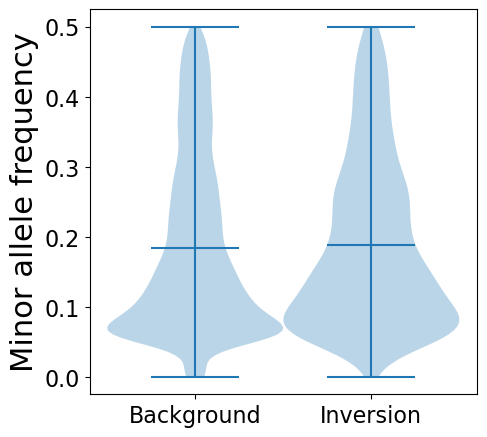

In [7]:
import pandas as pd

levels = ["low","mod", "high"]

df_all = pd.DataFrame()
for l in levels:
    file_path = os.path.expanduser(f'snpeff_remote/snpeff_results/{l}_{cname}_snpeff_freq.txt.frq')
    df1 = pd.read_csv(file_path, delimiter='\t')  # Use delimiter='\t' if the file is tab-separated
    df1[['ref', 'AF1']] = df1['N_CHR'].str.split(':', expand=True)
    df1[['alt', 'AF2']] = df1['{ALLELE:FREQ}'].str.split(':', expand=True)
    df1['MAF'] = df1[['AF1', 'AF2']].min(axis=1)
    df1['MAF'] = df1['MAF'].astype(float)
    df_all = pd.concat([df_all, df1], ignore_index=True)

df_inv = pd.DataFrame()
for l in levels:
    file_path = os.path.expanduser(f'snpeff_remote/snpeff_results/{l}_{cname}_inv_snpeff_freq.txt.frq')
    df1 = pd.read_csv(file_path, delimiter='\t')  # Use delimiter='\t' if the file is tab-separated
    #df1=df1[((df1["CHROM"]<=13424367) & (df1["CHROM"]>=12702886)) |  (df1["CHROM"]<=16793794) & (df1["CHROM"]>=15422748)]
    df1[['ref', 'AF1']] = df1['N_CHR'].str.split(':', expand=True)
    df1[['alt', 'AF2']] = df1['{ALLELE:FREQ}'].str.split(':', expand=True)
    df1['MAF'] = df1[['AF1', 'AF2']].min(axis=1)
    df1['MAF'] = df1['MAF'].astype(float)
    df_inv = pd.concat([df_inv, df1], ignore_index=True)

import seaborn as sns
plt.figure(figsize=(5,5))
positions = [1, 1.5]
plt.violinplot([df_all["MAF"].tolist(), df_inv["MAF"].tolist()], showmeans=True, positions=positions)
plt.ylabel("Minor allele frequency", fontsize=22)
plt.xticks([1, 1.5], ["Background", "Inversion"], fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("figs/606_MAF.pdf", format='pdf', bbox_inches='tight')

stat, p_value = mannwhitneyu(df_all["MAF"].tolist(), df_inv["MAF"].tolist(), alternative='two-sided')
print(p_value)
print(sum(df_all["MAF"].tolist())/len(df_all["MAF"].tolist()))
print(sum(df_inv["MAF"].tolist())/len(df_inv["MAF"].tolist()))

/users/c/p/cpetak/miniconda3/envs/wgs/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/wgs/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

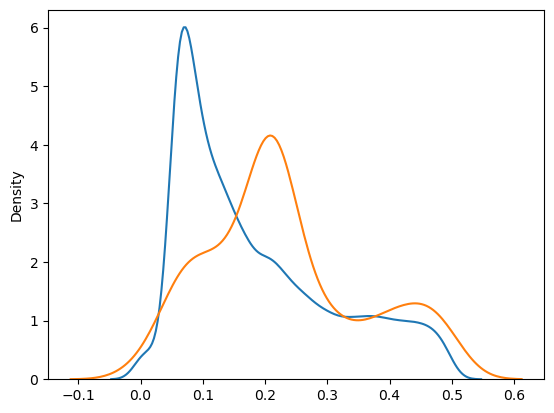

In [32]:
import seaborn as sns
sns.kdeplot(df_all["MAF"].tolist()) #
sns.kdeplot(df_inv["MAF"].tolist())